Name: Aditya Gujar<br>
Reg no: 2448505<br>
Lab-1

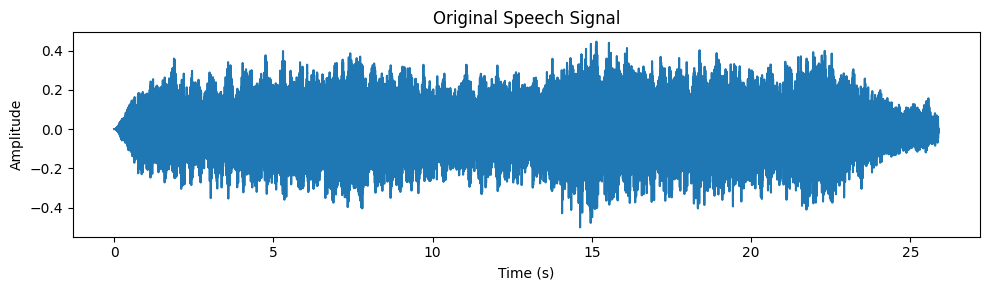

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

x, fs = librosa.load("atmosphere-sound-effect.mp3", sr=None)

t = np.linspace(0, len(x)/fs, len(x))

plt.figure(figsize=(10, 3))
plt.plot(t, x)
plt.title("Original Speech Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

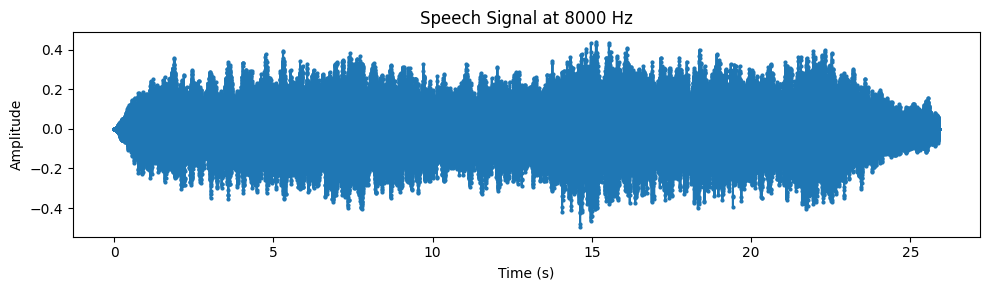

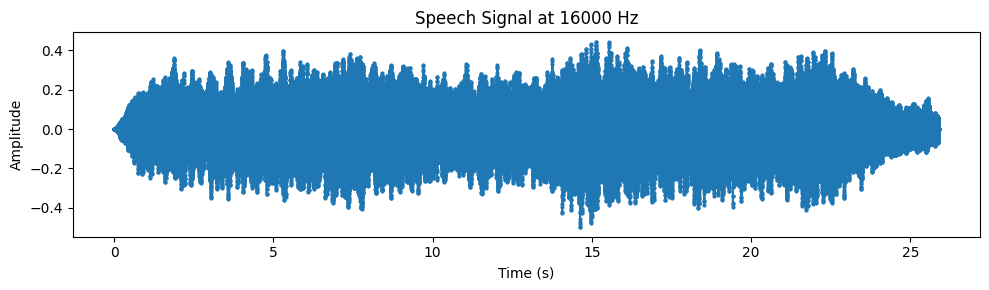

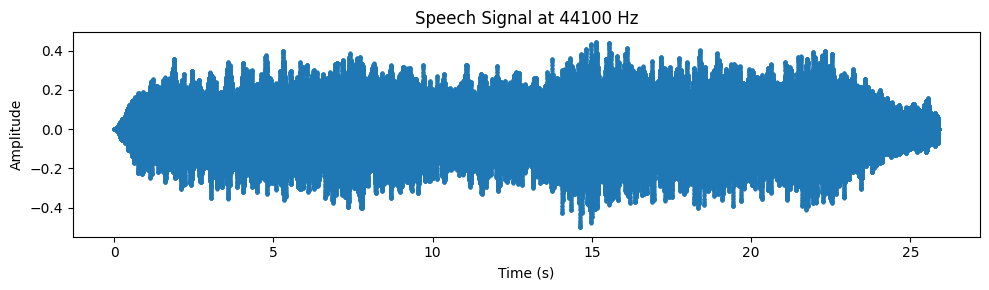

In [3]:
rates = [8000, 16000, 44100]
sampled_signals = {}

for r in rates:
    sampled = librosa.resample(x, orig_sr=fs, target_sr=r)
    sampled_signals[r] = sampled
    
    # New time axis for the resampled signal
    t_r = np.linspace(0, len(sampled) / r, len(sampled), endpoint=False)
    
    plt.figure(figsize=(10,3))
    plt.plot(t_r, sampled, 'o-', markersize=2)  # 'o-' shows sample points
    plt.title(f"Speech Signal at {r} Hz")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

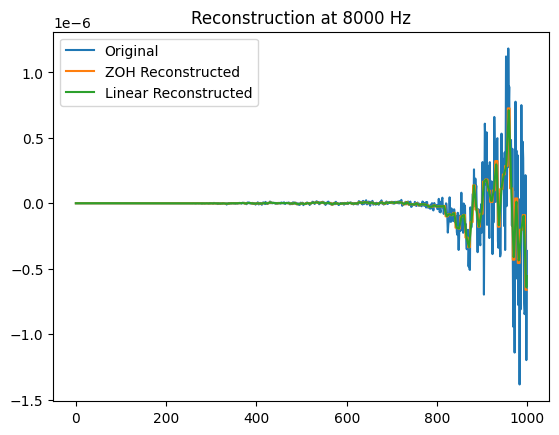

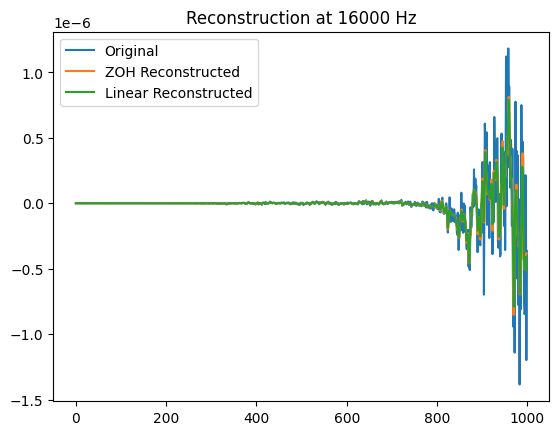

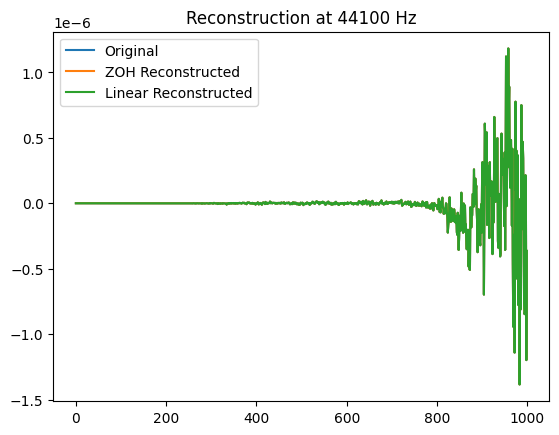

In [ ]:
def reconstruct(sampled, fs_original, fs_new, method="linear"):
    t_sampled = np.linspace(0, len(sampled)/fs_new, len(sampled))
    t_original = np.linspace(0, len(sampled)/fs_new, int(len(sampled) * fs_original / fs_new))

    if method == "zoh":  # Zero-order hold
        f = interpolate.interp1d(t_sampled, sampled, kind='nearest', fill_value="extrapolate")
    else:  # Linear
        f = interpolate.interp1d(t_sampled, sampled, kind='linear', fill_value="extrapolate")
    
    return f(t_original)

for r, sig in sampled_signals.items():
    zoh = reconstruct(sig, fs, r, method="zoh")
    lin = reconstruct(sig, fs, r, method="linear")
    
    plt.figure()
    plt.plot(x[:1000], label="Original")
    plt.plot(zoh[:1000], label="ZOH Reconstructed")
    plt.plot(lin[:1000], label="Linear Reconstructed")
    plt.title(f"Reconstruction at {r} Hz")
    plt.legend()
    plt.show()

In [7]:
def mse(a, b):
    N = min(len(a), len(b))
    return np.mean((a[:N] - b[:N])**2)

for r, sig in sampled_signals.items():
    zoh = reconstruct(sig, fs, r, method="zoh")
    lin = reconstruct(sig, fs, r, method="linear")
    print(f"Rate {r} Hz -> ZOH MSE: {mse(x, zoh):.6f}, Linear MSE: {mse(x, lin):.6f}")

Rate 8000 Hz -> ZOH MSE: 0.000343, Linear MSE: 0.000241
Rate 16000 Hz -> ZOH MSE: 0.000058, Linear MSE: 0.000032
Rate 44100 Hz -> ZOH MSE: 0.000000, Linear MSE: 0.000000


## Part-2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate

def mse(a, b):
    N = min(len(a), len(b))
    return np.mean((a[:N] - b[:N])**2)

def plot_short(time, sig, title, zoom_s=0.05):
    n = int(zoom_s * len(time) / time[-1])
    plt.figure(figsize=(8,2))
    plt.plot(time[:n], sig[:n])
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

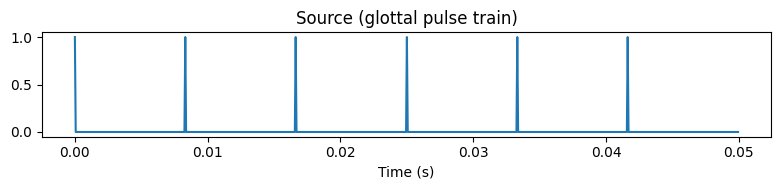

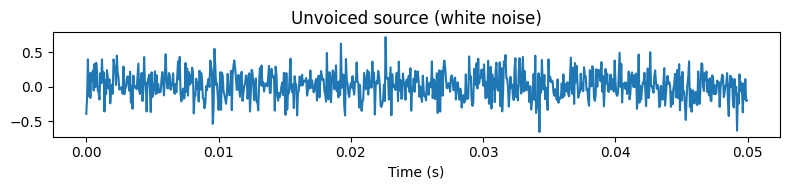

In [ ]:
fs = 16000         # synthesis sampling rate (Hz)
duration = 1.0     # seconds
t = np.linspace(0, duration, int(fs*duration), endpoint=False)

# Voiced: simple impulse train (glottal pulses)
pitch = 120                    # Hz
period = 1.0 / pitch
pulse_times = np.arange(0, duration, period)
source_voiced = np.zeros_like(t)
pulse_idx = (pulse_times * fs).astype(int)
pulse_idx = pulse_idx[pulse_idx < len(source_voiced)]
source_voiced[pulse_idx] = 1.0

# Unvoiced: white noise (smaller amplitude)
source_unvoiced = 0.2 * np.random.randn(len(t))

# Choose source (voiced for vowel-like)
source = source_voiced

plot_short(t, source, "Source (glottal pulse train)")
plot_short(t, source_unvoiced, "Unvoiced source (white noise)")

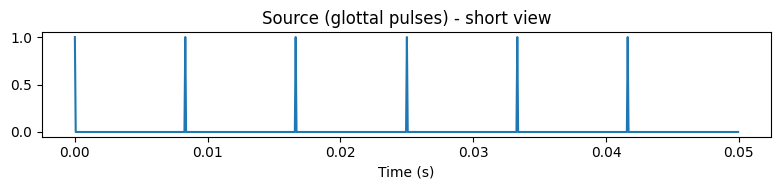

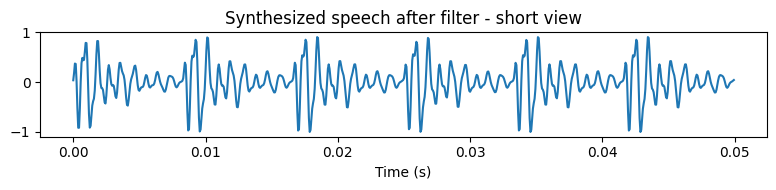

In [ ]:
# Example formants for vowel "a": around 730, 1090, 2440 Hz
formants = [730.0, 1090.0, 2440.0]
bandwidths = [80.0, 90.0, 120.0]   # larger -> wider, smaller -> sharper

s = source.copy()
for f, bw in zip(formants, bandwidths):
    # design a second-order resonant filter (iirpeak)
    # iirpeak expects normalized freq (0..1) where 1 is Nyquist
    w0 = f / (fs / 2.0)
    Q = f / bw
    b, a = signal.iirpeak(w0, Q)
    s = signal.lfilter(b, a, s)

# Normalize
synth = s / (np.max(np.abs(s)) + 1e-12)

# Plot source vs synth
plot_short(t, source, "Source (glottal pulses) - short view")
plot_short(t, synth,  "Synthesized speech after filter - short view")

Resampled to 8000 Hz -> 8000 samples


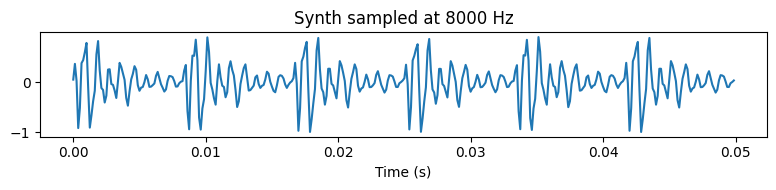

Resampled to 16000 Hz -> 16000 samples


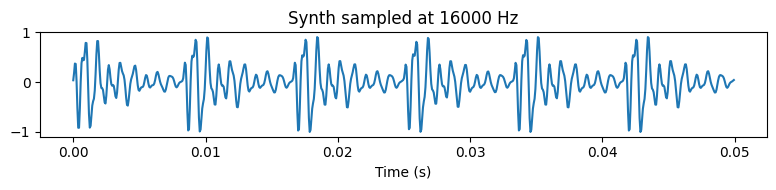

Resampled to 44100 Hz -> 44100 samples


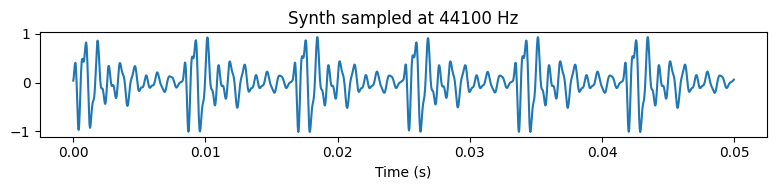

In [ ]:
target_rates = [8000, 16000, 44100]
sampled = {}

for r in target_rates:
    # Use scipy.signal.resample: specify number of samples for target rate
    n_samples = int(round(duration * r))
    sampled_sig = signal.resample(synth, n_samples)
    sampled[r] = sampled_sig
    print(f"Resampled to {r} Hz -> {len(sampled_sig)} samples")
    # plot first 50 ms of each sampled signal (time axis for that rate)
    t_r = np.linspace(0, duration, len(sampled_sig), endpoint=False)
    plot_short(t_r, sampled_sig, f"Synth sampled at {r} Hz")

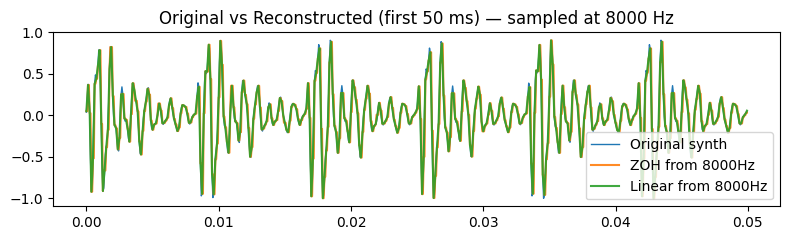

8000 Hz -> ZOH MSE: 1.44724672e-02, Linear MSE: 1.61210945e-03


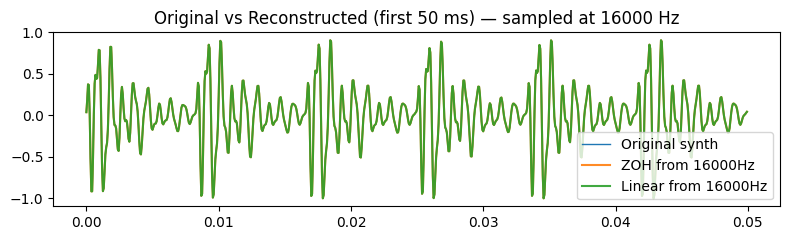

16000 Hz -> ZOH MSE: 1.45900523e-32, Linear MSE: 1.46636182e-32


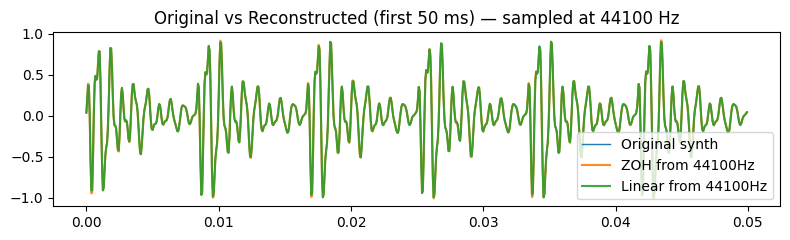

44100 Hz -> ZOH MSE: 3.30157037e-04, Linear MSE: 2.09797601e-06


In [ ]:
from scipy.interpolate import interp1d

recon = {}
for r, s_sig in sampled.items():
    # time axes
    t_sampled = np.linspace(0, duration, len(s_sig), endpoint=False)
    t_target = np.linspace(0, duration, len(synth), endpoint=False)

    # Zero-Order Hold (nearest)
    f_nearest = interp1d(t_sampled, s_sig, kind='nearest', fill_value="extrapolate")
    recon_zoh = f_nearest(t_target)

    # Linear interpolation
    f_linear = interp1d(t_sampled, s_sig, kind='linear', fill_value="extrapolate")
    recon_lin = f_linear(t_target)

    recon[r] = {"zoh": recon_zoh, "linear": recon_lin}

    # Plots: short overlay
    n_show = int(0.05 * fs)
    plt.figure(figsize=(8,2.5))
    plt.plot(t[:n_show], synth[:n_show], label="Original synth", linewidth=1)
    plt.plot(t[:n_show], recon_zoh[:n_show], label=f"ZOH from {r}Hz", alpha=0.9)
    plt.plot(t[:n_show], recon_lin[:n_show], label=f"Linear from {r}Hz", alpha=0.9)
    plt.title(f"Original vs Reconstructed (first 50 ms) — sampled at {r} Hz")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # compute MSEs
    print(f"{r} Hz -> ZOH MSE: {mse(synth, recon_zoh):.8e}, Linear MSE: {mse(synth, recon_lin):.8e}")